In [1]:
# Import
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pandas_datareader import data
import datetime as dt


C:\Users\janesley\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Items needed for options class
CUR_MONTH = dt.datetime.now().month
CUR_YEAR = dt.datetime.now().year
CUR_DAY = dt.datetime.now().day

data = pd.read_csv('../Data/data_stocks.csv')


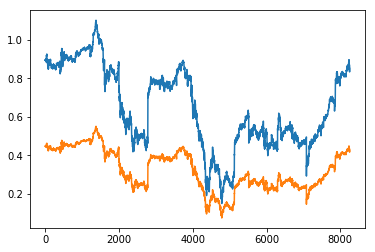

MSE Train:  1.1515193
MSE Test:  2.0927486
MSE Train:  0.0007364645
MSE Test:  0.043476455
MSE Train:  0.00019712391
MSE Test:  0.04609317
MSE Train:  0.00026772678
MSE Test:  0.044555582
MSE Train:  0.00018352417
MSE Test:  0.042343933
MSE Train:  0.00010435676
MSE Test:  0.03985709
MSE Train:  0.000147542
MSE Test:  0.038208075
MSE Train:  0.00011395398
MSE Test:  0.03216267
MSE Train:  0.00034103423
MSE Test:  0.033391014
MSE Train:  0.0001698637
MSE Test:  0.02617904
MSE Train:  0.00011423533
MSE Test:  0.027444635
MSE Train:  7.672299e-05
MSE Test:  0.02404966
MSE Train:  9.6120886e-05
MSE Test:  0.021184703
MSE Train:  0.000105816995
MSE Test:  0.019860717
MSE Train:  6.294571e-05
MSE Test:  0.01917647
MSE Train:  9.537411e-05
MSE Test:  0.016398117
MSE Train:  6.2220744e-05
MSE Test:  0.018171506
MSE Train:  9.370882e-05
MSE Test:  0.019386193
MSE Train:  6.759503e-05
MSE Test:  0.01603156
MSE Train:  8.61148e-05
MSE Test:  0.017014123
MSE Train:  8.199099e-05
MSE Test:  0.01539

In [3]:

# Drop date variable
data = data.drop(['DATE'], 1)

# Dimensions of dataset
n = data.shape[0]
p = data.shape[1]

# Make data a np.array
data = data.values

# Training and test data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

# Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

# Number of stocks in training data
n_stocks = X_train.shape[1]

# Neurons
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128

# Session
net = tf.InteractiveSession()

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output weights
W_out = tf.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.Variable(bias_initializer([1]))

# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# Init
net.run(tf.global_variables_initializer())

# Setup plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test * 0.5)
plt.show()

# Fit neural net
batch_size = 256
mse_train = []
mse_test = []

# Run
epochs = 10
for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 50) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})

In [4]:
# Print final MSE after Training
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print(mse_final)

0.007094775


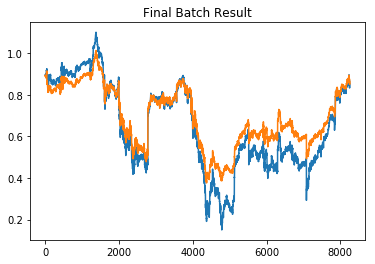

In [7]:
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(pred[0,:])
plt.title('Final Batch Result')
plt.show()